In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

pd.set_option('display.float_format', '{:.4f}'.format)

# Descarga de datos

In [23]:
# Descargar datos históricos de Ford (F)
ticker = "F"
start_date = "2023-01-01"
end_date = "2025-04-28"

data = yf.download(ticker, start=start_date, end=end_date, progress=False)['Close']
rt = data.pct_change().dropna()

current_price = data.iloc[-1].iloc[0]
r = 0.04
sigma = rt.std() * np.sqrt(252)
mu = rt.mean() * 252 

print(f"Precio actual de {ticker}: ${current_price:.2f}")
print(f"Volatilidad anualizada: {sigma.iloc[0]*100:.2f}%")
print(f"Rendimiento esperado anualizado: {mu.iloc[0]*100:.2f}%")

Precio actual de F: $10.04
Volatilidad anualizada: 36.33%
Rendimiento esperado anualizado: 8.83%


# Funciones para el cálculo de la prima

In [24]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Simulación del precio con montecarlo antitetico

In [ ]:
def monte_carlo_antithetic(S0, mu, sigma, T, num_simulations, num_steps):
    # Reducimos a la mitad el número de simulaciones porque generaremos pares
    actual_sims = num_simulations // 2
    dt = T/num_steps
    price_paths = np.zeros((num_simulations, num_steps+1))
    price_paths[:,0] = S0
    
    for i in range(actual_sims):
        for j in range(1, num_steps+1):
            z = np.random.normal(0, 1)
            price_paths[i,j] = price_paths[i,j-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
            price_paths[i+actual_sims,j] = price_paths[i+actual_sims,j-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * (-z))
    return price_paths

In [ ]:
# Parámetros de simulación
num_simulations = 100  # Nota: Se generarán el doble de caminos (50 normales + 50 antitéticos)
num_steps_month = 21  # 1 mes
num_steps_quarter = 63  # 3 meses
num_steps_year = 252  # 1 año

# Ejecutar simulaciones con método antitético
sim_month = monte_carlo_antithetic(current_price, mu, sigma, 1/12, num_simulations, num_steps_month)
sim_quarter = monte_carlo_antithetic(current_price, mu, sigma, 0.25, num_simulations, num_steps_quarter)
sim_year = monte_carlo_antithetic(current_price, mu, sigma, 1, num_simulations, num_steps_year)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Precio actual de F: $10.04
Volatilidad anualizada: 44.31%


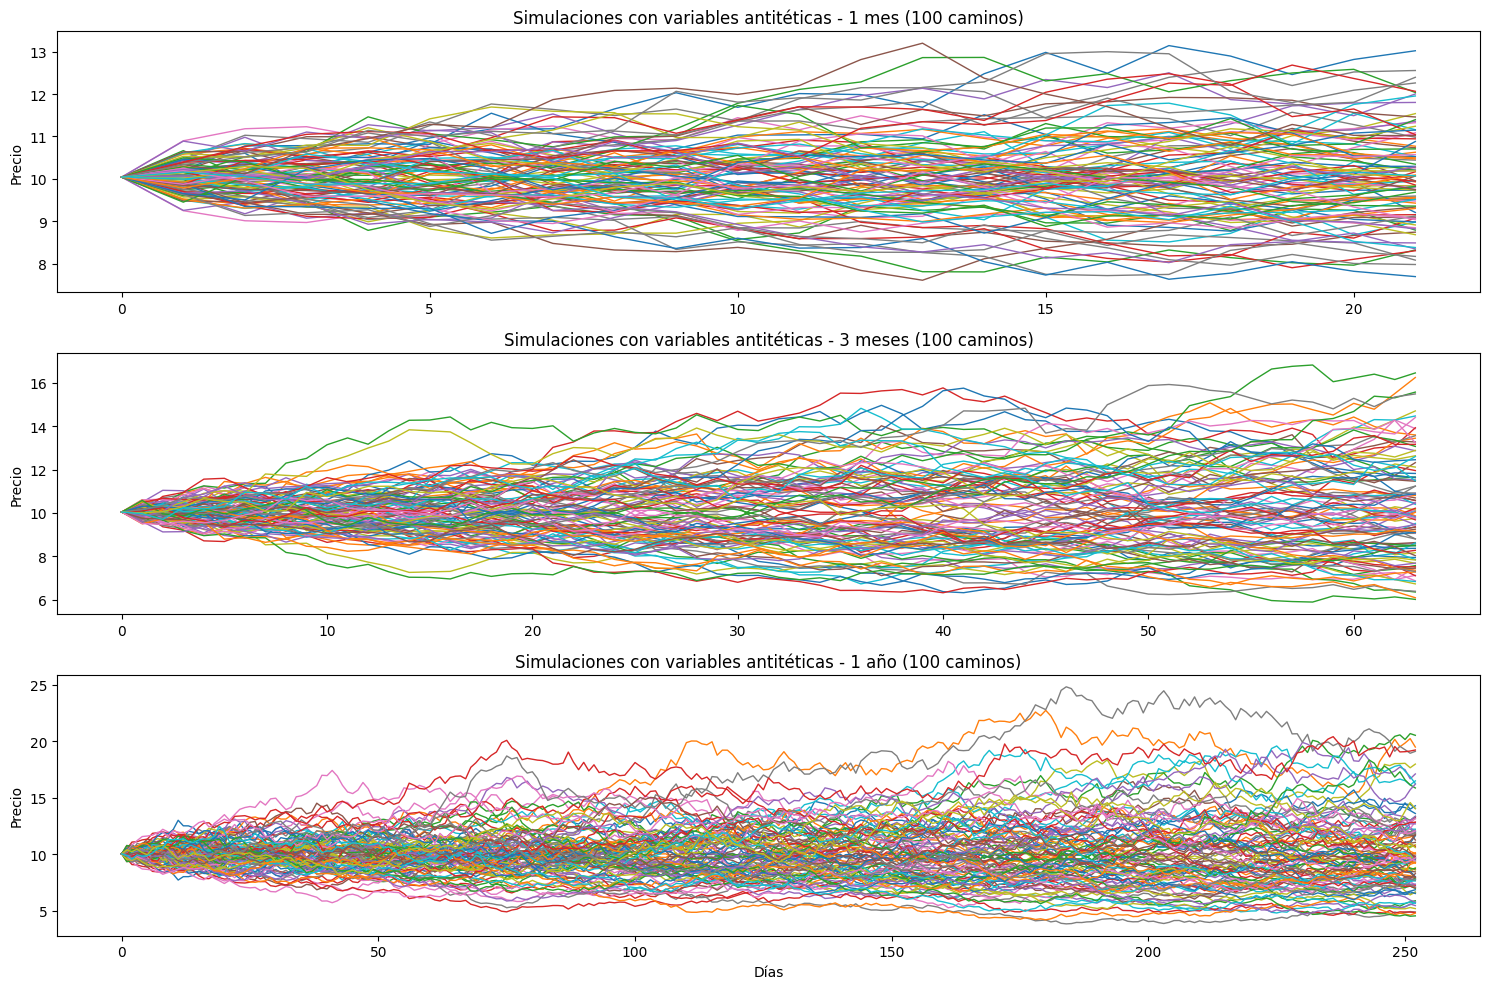


Collar para 1.0 meses con variables antitéticas:
- Put Strike (95% S): $9.54, Prima: $0.27
- Call Strike (105% S): $10.54, Prima: $0.33
- Costo neto: $-0.05

Collar para 3.0 meses con variables antitéticas:
- Put Strike (95% S): $9.54, Prima: $0.58
- Call Strike (105% S): $10.54, Prima: $0.73
- Costo neto: $-0.15

Collar para 12.0 meses con variables antitéticas:
- Put Strike (95% S): $9.54, Prima: $1.23
- Call Strike (105% S): $10.54, Prima: $1.77
- Costo neto: $-0.53


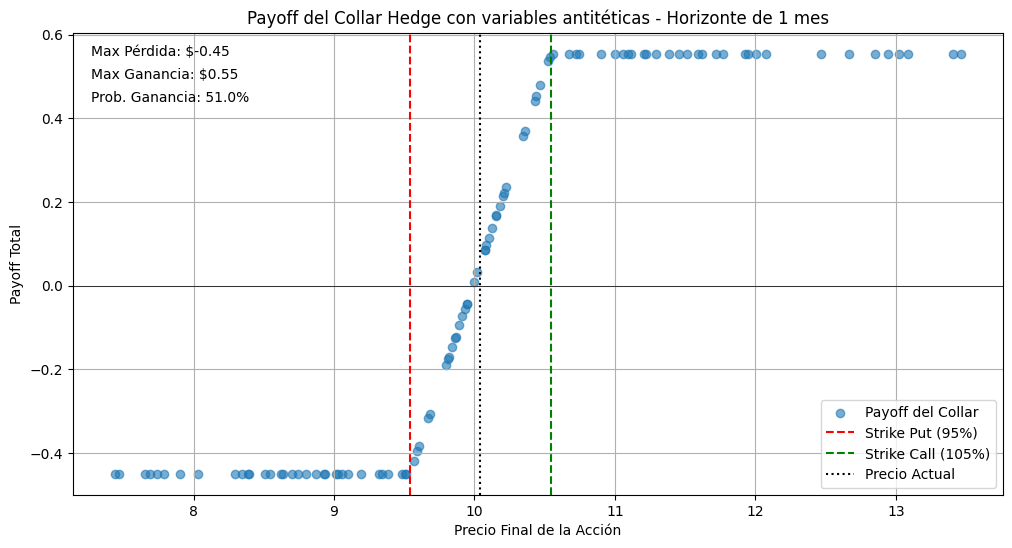

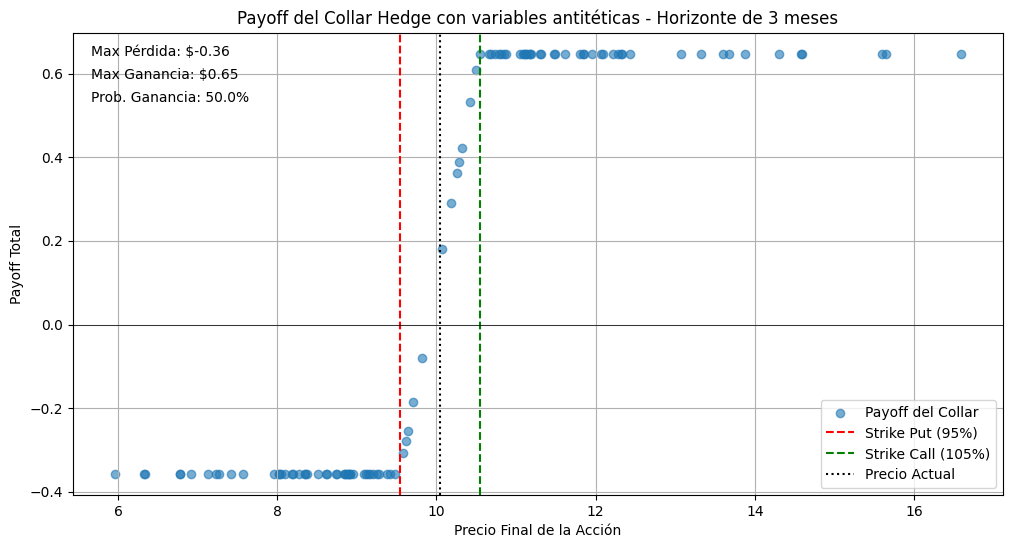

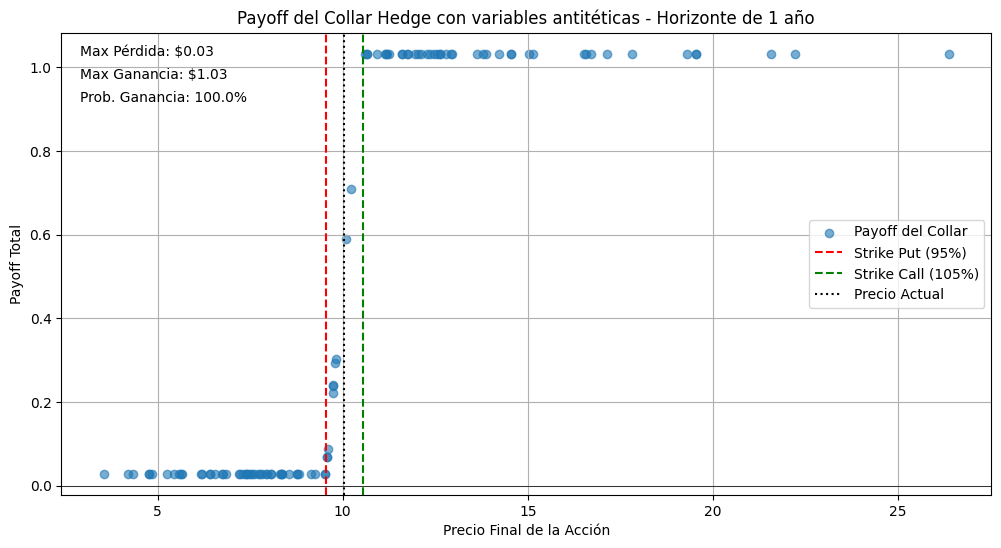

In [ ]:


# Graficar simulaciones (ahora incluye caminos antitéticos)
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
for i in range(num_simulations):
    plt.plot(sim_month[i], lw=1)
plt.title(f'Simulaciones con variables antitéticas - 1 mes ({num_simulations} caminos)')
plt.ylabel('Precio')

plt.subplot(3, 1, 2)
for i in range(num_simulations):
    plt.plot(sim_quarter[i], lw=1)
plt.title(f'Simulaciones con variables antitéticas - 3 meses ({num_simulations} caminos)')
plt.ylabel('Precio')

plt.subplot(3, 1, 3)
for i in range(num_simulations):
    plt.plot(sim_year[i], lw=1)
plt.title(f'Simulaciones con variables antitéticas - 1 año ({num_simulations} caminos)')
plt.ylabel('Precio')
plt.xlabel('Días')

plt.tight_layout()
plt.show()

# Función para crear collar con simulaciones antitéticas
def create_collar_antithetic(S, T, r, sigma, num_simulations, num_steps):
    put_strike = S * 0.95
    call_strike = S * 1.05
    
    put_premium = black_scholes_put(S, put_strike, T, r, sigma)
    call_premium = black_scholes_call(S, call_strike, T, r, sigma)
    
    print(f"\nCollar para {T*12:.1f} meses con variables antitéticas:")
    print(f"- Put Strike (95% S): ${put_strike:.2f}, Prima: ${put_premium:.2f}")
    print(f"- Call Strike (105% S): ${call_strike:.2f}, Prima: ${call_premium:.2f}")
    print(f"- Costo neto: ${put_premium - call_premium:.2f}")
    
    paths = monte_carlo_antithetic(S, mu, sigma, T, num_simulations, num_steps)
    final_prices = paths[:,-1]
    
    stock_payoff = final_prices - S
    put_payoff = np.maximum(put_strike - final_prices, 0) - put_premium
    call_payoff = call_premium - np.maximum(final_prices - call_strike, 0)
    total_payoff = stock_payoff + put_payoff + call_payoff
    
    return final_prices, total_payoff, put_strike, call_strike

# Crear collares con método antitético
final_prices_month, payoff_month, put_strike_month, call_strike_month = create_collar_antithetic(current_price, 1/12, r, sigma, num_simulations, num_steps_month)
final_prices_quarter, payoff_quarter, put_strike_quarter, call_strike_quarter = create_collar_antithetic(current_price, 0.25, r, sigma, num_simulations, num_steps_quarter)
final_prices_year, payoff_year, put_strike_year, call_strike_year = create_collar_antithetic(current_price, 1, r, sigma, num_simulations, num_steps_year)

# Función para graficar payoff (sin cambios)
def plot_collar_payoff(final_prices, payoff, put_strike, call_strike, S, horizon):
    plt.figure(figsize=(12, 6))
    
    plt.scatter(final_prices, payoff, alpha=0.6, label='Payoff del Collar')
    plt.axvline(x=put_strike, color='r', linestyle='--', label='Strike Put (95%)')
    plt.axvline(x=call_strike, color='g', linestyle='--', label='Strike Call (105%)')
    plt.axvline(x=S, color='k', linestyle=':', label='Precio Actual')
    plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    
    plt.title(f'Payoff del Collar Hedge con variables antitéticas - Horizonte de {horizon}')
    plt.xlabel('Precio Final de la Acción')
    plt.ylabel('Payoff Total')
    plt.legend()
    plt.grid(True)
    
    max_loss = payoff.min()
    max_gain = payoff.max()
    prob_profit = len(payoff[payoff > 0]) / len(payoff) * 100
    
    plt.text(0.02, 0.95, f"Max Pérdida: ${max_loss:.2f}", transform=plt.gca().transAxes)
    plt.text(0.02, 0.90, f"Max Ganancia: ${max_gain:.2f}", transform=plt.gca().transAxes)
    plt.text(0.02, 0.85, f"Prob. Ganancia: {prob_profit:.1f}%", transform=plt.gca().transAxes)
    
    plt.show()

# Graficar resultados
plot_collar_payoff(final_prices_month, payoff_month, put_strike_month, call_strike_month, current_price, "1 mes")
plot_collar_payoff(final_prices_quarter, payoff_quarter, put_strike_quarter, call_strike_quarter, current_price, "3 meses")
plot_collar_payoff(final_prices_year, payoff_year, put_strike_year, call_strike_year, current_price, "1 año")